In [1]:
import os, glob, math, json
import numpy as np
import pandas as pd
import tensorflow as tf

from PIL import Image
from datetime import datetime
import matplotlib.pyplot as plt

In [2]:
print (tf.__version__)

2.1.0


# 0. Data Pre-analysis

In [3]:
train_width, train_height = [], []
train_channel = set()

In [4]:
for prog in os.listdir('dataset'):
    for fname in glob.glob(os.path.join('dataset', prog, '*.png')):
        im = Image.open(fname)
        w, h = im.size
        train_width.append(w)
        train_height.append(h)
        train_channel.add(im.getbands())
assert len(train_width) == len(train_height), "# Mismatch between N# height and width!"

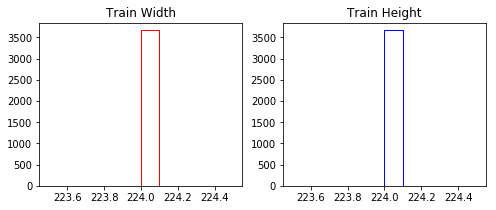

In [5]:
fig = plt.figure(figsize=(8, 3))
plt.subplot(1, 2, 1)
plt.title('Train Width')
plt.hist(train_width, color='red', label='Width', histtype='step')
plt.subplot(1, 2, 2)
plt.title('Train Height')
plt.hist(train_height, color='blue', label='Height', histtype='step')
plt.show()

In [6]:
print ('Image Channel: ', train_channel)

Image Channel:  {('L',)}


In [7]:
BATCH_SIZE = 32
IMG_HEIGHT = 224
IMG_WIDTH = 224
INPUT_SIZE = (IMG_HEIGHT, IMG_WIDTH)

In [8]:
print ("Getting Training Data")
trainGenerator = tf.keras.preprocessing.image.ImageDataGenerator(
                rescale=1./255, 
                rotation_range=30,
                zoom_range=0.15,
                width_shift_range=0.15, 
                height_shift_range=0.15, 
                horizontal_flip=True,
                vertical_flip=True,
                validation_split=0.2
                )

print ("Subsampling Training Set")
train_data = trainGenerator.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory='dataset',
                    #target_size=INPUT_SIZE,
                    subset='training',)
#                     color_mode='grayscale')
num_train_data = train_data.n

print ("Subsampling Validation Set")
val_data = trainGenerator.flow_from_directory(
                    batch_size=BATCH_SIZE,
                    directory='dataset',
                    #target_size=INPUT_SIZE,
                    subset='validation',)
                    #color_mode='grayscale')
num_val_data = val_data.n

labels = {z: dis for z, dis in enumerate(os.listdir('dataset'))}
print ("Labels: ", labels)

Getting Training Data
Subsampling Training Set
Found 2931 images belonging to 5 classes.
Subsampling Validation Set
Found 731 images belonging to 5 classes.
Labels:  {0: 'Mild', 1: 'No_DR', 2: 'Proliferate_DR', 3: 'Moderate', 4: 'Severe'}


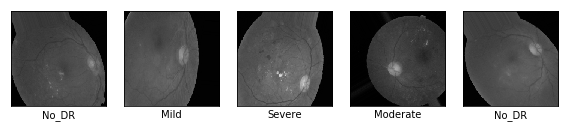

In [9]:
def decodeOneHot(one_hot_vector):
    return np.argmax(one_hot_vector)

def plotImages(images_arr, label_arr):
    """
    Displays a selection of images (e.g. from training dataset)
    with their appropriate labels.
    Input: array_of_images[n], 
        where n takes the form of array slicer.
    Output: plot(s) of rescaled images with their curated annotation.
    """
    fig, axes = plt.subplots(1, 5, figsize=(8,8))
    axes = axes.flatten()
    for img, dataLabel, ax in zip(images_arr, label_arr, axes):
        img = np.asarray(img)
        ax.imshow(img)#, cmap='gray')
        ax.set_xlabel(labels[decodeOneHot(dataLabel)])
        ax.set_yticks([])
        ax.set_xticks([])
    plt.tight_layout()
    plt.show()


sample_train, label = next(train_data)
plotImages(sample_train[:5], label[:5])

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu',
                           input_shape=(256, 256, 3)),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Dropout(0.2, seed=111),
    
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(3, strides=2),
    tf.keras.layers.Dropout(0.2, seed=111),
    
#     tf.keras.layers.Conv2D(96, 3, padding='same', activation='relu'),
#     tf.keras.layers.MaxPooling2D(3, strides=2),
#     tf.keras.layers.Dropout(0.2, seed=111),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.4, seed=111),
    tf.keras.layers.Dense(5, activation='softmax')
    ])
model.compile(optimizer=tf.keras.optimizers.Adam(),#epsilon=1e-3, ),
              loss='categorical_crossentropy',
              metrics=['accuracy', 'AUC', 'Precision', 'Recall'])
model.summary()
now = datetime.strftime(datetime.today(), '%Y%m%d_%H%M')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 127, 127, 32)      0         
_________________________________________________________________
dropout (Dropout)            (None, 127, 127, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 127, 127, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 254016)            0

In [11]:
early_stop = tf.keras.callbacks.EarlyStopping(patience=10, verbose=1)

LR_reduce = tf.keras.callbacks.ReduceLROnPlateau(
                            monitor='val_accuracy', 
                            patience=5, 
                            verbose=1, 
                            factor=2/3, 
                            min_lr=1e-5)
callbacks = [early_stop, LR_reduce]

In [12]:
with tf.device('/gpu:0'):
    history = model.fit(train_data, 
                        steps_per_epoch=math.ceil(num_train_data/BATCH_SIZE), 
                        epochs=50,
                        validation_data=val_data,
                        callbacks=callbacks)

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 92 steps, validate for 23 steps
Epoch 1/50
92/92 [==============================] - 39s 420ms/step - loss: 3.1394 - accuracy: 0.5128 - AUC: 0.7704 - Precision: 0.6439 - Recall: 0.3146 - val_loss: 1.1458 - val_accuracy: 0.5499 - val_AUC: 0.8247 - val_Precision: 0.8439 - val_Recall: 0.3475
Epoch 2/50
92/92 [==============================] - 37s 406ms/step - loss: 1.0359 - accuracy: 0.6261 - AUC: 0.8589 - Precision: 0.8145 - Recall: 0.4241 - val_loss: 1.0173 - val_accuracy: 0.6320 - val_AUC: 0.8766 - val_Precision: 0.9286 - val_Recall: 0.3379
Epoch 3/50
92/92 [==============================] - 37s 403ms/step - loss: 0.9785 - accuracy: 0.6520 - AUC: 0.8747 - Precision: 0.8149 - Recall: 0.4732 - val_loss: 0.9848 - val_accuracy: 0.6347 - val_AUC: 0.8693 - val_Precision: 0.8297 - val_Recall: 0.4200
Epoch 4/50
92/92 [==============================] - 37s 404ms/step - loss: 0.9596 - accuracy: 0.6595 - AUC: 0.8802 - Precision: 0.8034 - 

92/92 [==============================] - 37s 403ms/step - loss: 0.8204 - accuracy: 0.7073 - AUC: 0.9141 - Precision: 0.8331 - Recall: 0.5739 - val_loss: 0.8028 - val_accuracy: 0.7045 - val_AUC: 0.9210 - val_Precision: 0.8401 - val_Recall: 0.5103
Epoch 30/50
92/92 [==============================] - 37s 402ms/step - loss: 0.8183 - accuracy: 0.7086 - AUC: 0.9141 - Precision: 0.8206 - Recall: 0.5776 - val_loss: 0.8242 - val_accuracy: 0.6826 - val_AUC: 0.9164 - val_Precision: 0.8463 - val_Recall: 0.5048
Epoch 31/50
92/92 [==============================] - 37s 403ms/step - loss: 0.8205 - accuracy: 0.7056 - AUC: 0.9136 - Precision: 0.8217 - Recall: 0.5756 - val_loss: 0.8275 - val_accuracy: 0.7031 - val_AUC: 0.9178 - val_Precision: 0.8538 - val_Recall: 0.4952
Epoch 32/50
92/92 [==============================] - 37s 403ms/step - loss: 0.8200 - accuracy: 0.7049 - AUC: 0.9143 - Precision: 0.8251 - Recall: 0.5681 - val_loss: 0.8174 - val_accuracy: 0.6895 - val_AUC: 0.9160 - val_Precision: 0.8379 -

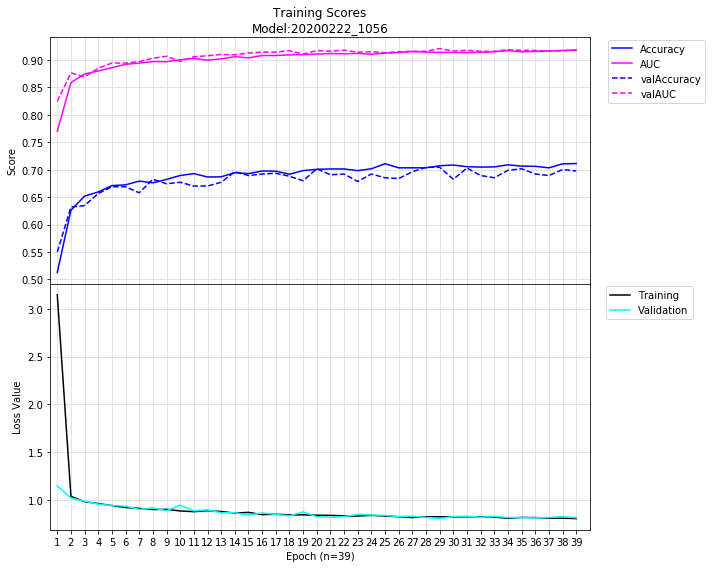

True

In [13]:
def plotHistory(history, plot=False):
    """
    Plots the evalation metrics of the trained model. Included metrics are
    accuracy, AUC, and loss in both training and validation data. Optionally,
    precision and recall metrics can also be plotted.
    Input: training history object
    Output: Two subplots showing the evaluation scores w.r.t. to the epoch.

    Note: any missing key (evaluation metric) from the history.history 
    dictionary will raise an exception and the plots would not be generated.
    The first missing key will be printed as the exception.
    """
    try:
        fig = plt.figure(figsize=(10, 8))
        plt.subplot(2, 1, 1)
        minVal, maxVal = 1, 0
        finalEpoch = len(history.history['accuracy'])
        for result in history.history:
            if 'loss' not in result:
                for val in history.history[result]:
                    if val < minVal: minVal = val
                    if val > maxVal: maxVal = val
        plt.title(f'Training Scores\nModel:{now}')
        plt.plot(range(1, finalEpoch+1), history.history['accuracy'], 
                 color='blue', label='Accuracy')
        plt.plot(range(1, finalEpoch+1), history.history['AUC'], 
                 color='magenta', label='AUC')
        plt.plot(range(1, finalEpoch+1), history.history['val_accuracy'], '--', 
                 color='blue', label='valAccuracy')
        plt.plot(range(1, finalEpoch+1), history.history['val_AUC'], '--', 
                 color='magenta', label='valAUC')
        plt.xticks(range(1, finalEpoch+1, 1))
        plt.xlim((0.5, finalEpoch+1))
        plt.ylabel('Score')
        plt.grid(color='#DDDDDD')
        plt.tick_params(axis='x', labelcolor='#FFFFFF')
        plt.legend(bbox_to_anchor=(1.025, 1.01))
        plt.subplots_adjust(hspace=0.001)

        plt.subplot(2, 1, 2)
        plt.ylabel('Loss Value')
        plt.xlabel(f'Epoch (n={finalEpoch})')
        plt.xticks(range(1, finalEpoch+1, 1))
        plt.xlim((0.5, finalEpoch+1))
        plt.plot(range(1, finalEpoch+1), history.history['loss'], 
                 color='black', label='Training')
        plt.plot(range(1, finalEpoch+1), history.history['val_loss'], 
                 color='cyan', label='Validation')
        plt.grid(color='#DDDDDD')
        plt.legend(bbox_to_anchor=(1.2, 1.01))
        plt.tight_layout()
        plt.subplots_adjust(hspace=0)
        plt.show()
        if plot:
            plt.savefig(os.path.join(PROJECT_PATH, 
                                     f'{now}.png'))
        return True
    except Exception as E:
        print ('Unable to produce figure, missing key:', E) 
        return False

plotHistory(history, False)

In [14]:
with tf.Session() as sess:
    devices = sess.list_devices()
    print (devices)
        

AttributeError: module 'tensorflow' has no attribute 'Session'